In [5]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from SimPEG import Mesh
import pandas as pd

from pathlib import Path
import pandas as pd
import fileinput
# import cartopy

In [6]:
datadir = Path('../data/raw_data')
data17dir = datadir.joinpath('AEM_data_2017_avg')
data19dir = datadir.joinpath('AEM_data_2019_avg')

data17 = datadir.joinpath('AEM_data_2017','MCWD3_SCI1i_MOD_dat.xyz')
data19 = datadir.joinpath('AEM_data_2019','MCWD19_SCI8i_MOD_dat.xyz')
df17 = pd.read_csv(data17,header=20,delim_whitespace=True)
df19 = pd.read_csv(data19,header=20,delim_whitespace=True)

df17 = df17.assign(skytem_type=304)
df19 = df19.assign(skytem_type=312)
# df = pd.concat((df17,df19),sort=False)


In [7]:
df = pd.read_pickle(datadir.joinpath('processed_df_1719.pkl'))
line = 100501

In [4]:
#TAKE THE LOCATION OF CHANNEL 1 FOR EACH SOUNDING
msk = np.logical_and(df.CHANNEL_NO==1, df.LINE_NO == line)
xy = df.loc[msk,['UTMX', 'UTMY']].values
Line = df.LINE_NO.values
dem = df.loc[msk,'ELEVATION'].values[:]
height = df.loc[msk,'INVALT'].values[:]
rx_locations = np.c_[xy[:,:], height+dem+2.]
src_locations = np.c_[xy[:,:], height+dem]
topo = np.c_[xy[:,:], dem]
skytem_type = df.skytem_type.values

In [33]:
area = 342
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_312.txt'))
waveform_lm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_312.txt'))
time_input_currents_HM_312 = waveform_hm_312[:,0] 
input_currents_HM_312 = waveform_hm_312[:,1]
time_input_currents_LM_312 = waveform_lm_312[:,0] 
input_currents_LM_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-1.8E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312

GateTimeShift=-1.4E-06
MeaTimeDelay=6.000E-05
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

In [34]:
area = 342
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_304.txt'))
waveform_lm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_304.txt'))
time_input_currents_HM_304 = waveform_hm_304[:,0] 
input_currents_HM_304 = waveform_hm_304[:,1]
time_input_currents_LM_304 = waveform_lm_304[:,0] 
input_currents_LM_304 = waveform_lm_304[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-2.1E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_304 = waveform_lm_304[:,0].max()
times_lm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_304

GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_304 = waveform_hm_304[:,0].max()
times_hm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_304    

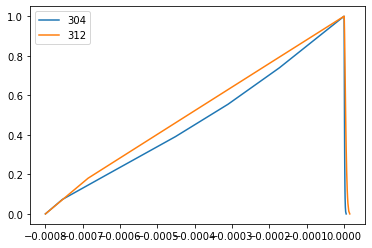

In [35]:
plt.plot(time_input_currents_LM_304, input_currents_LM_304,label='304')
plt.plot(time_input_currents_LM_312, input_currents_LM_312,label='312')
plt.legend()

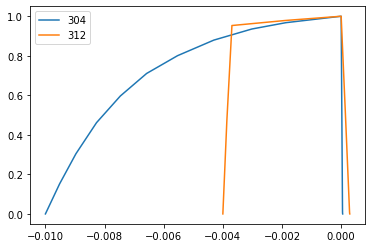

In [36]:
plt.plot(time_input_currents_HM_304, input_currents_HM_304,label='304')
plt.plot(time_input_currents_HM_312, input_currents_HM_312,label='312')
plt.legend()

In [37]:
from SimPEG import (
    Regularization, Directives, Inversion, 
    InvProblem, Optimization, DataMisfit, Utils, Maps
)
from simpegEM1D import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, 
    get_vertical_discretization_time, EM1DSurveyTD,
    get_2d_mesh, LateralConstraint, 
)
from pymatsolver import PardisoSolver
hz_312 = np.loadtxt(datadir.joinpath('AEM_data_2019','thickness.txt'))
hz_304 = np.loadtxt(datadir.joinpath('AEM_data_2017','thickness.txt'))


hz = hz_304
# hz = np.unique(hz_312.values[inds_312,:])* 0.3048
# hz = np.unique(hz_304.values[inds_304,:])* 0.3048
n_sounding = xy.shape[0]
mesh = get_2d_mesh(n_sounding, hz)

In [38]:
time = []
time_dual_moment = []
input_currents = []
time_input_currents = []
input_currents_dual_moment = []
time_input_currents_dual_moment = []

for i_sounding in range(n_sounding):
    if skytem_type[i_sounding] == 312.:
        time.append(times_hm_312)
        time_dual_moment.append(times_lm_312)
        time_input_currents.append(time_input_currents_HM_312)
        input_currents.append(input_currents_HM_312)
        time_input_currents_dual_moment.append(time_input_currents_LM_312)
        input_currents_dual_moment.append(input_currents_LM_312)        
    else:
        time.append(times_hm_304)
        time_dual_moment.append(times_lm_304)
        time_input_currents.append(time_input_currents_HM_304)
        input_currents.append(input_currents_HM_304)
        time_input_currents_dual_moment.append(time_input_currents_LM_304)
        input_currents_dual_moment.append(input_currents_LM_304)        

In [39]:
len(time_dual_moment[0])

18

In [40]:
# print(survey.nD)
# print(src_locations.shape)
# print(n_sounding)
# print(len(time)*len(time[0]) + len(time_dual_moment)*len(time_dual_moment[0]))
# print(uncert.shape)

In [41]:
mapping = Maps.ExpMap(mesh)

survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations[:,:],
    src_locations = src_locations[:,:],    
    topo = topo[:,:],
    time = time,
    time_dual_moment = time_dual_moment,
    src_type = np.array(["VMD"], dtype=str).repeat(n_sounding),
    rx_type = np.array(["dBzdt"], dtype=str).repeat(n_sounding),    
    offset = np.array([13.25], dtype=float).repeat(n_sounding).reshape([-1,1]),    
    wave_type = np.array(["general"], dtype=str).repeat(n_sounding),    
    field_type = np.array(["secondary"], dtype=str).repeat(n_sounding),    
    input_currents=input_currents,
    time_input_currents=time_input_currents,
    base_frequency = np.array([30.]).repeat(n_sounding),
    input_currents_dual_moment=input_currents_dual_moment,
    time_input_currents_dual_moment=time_input_currents_dual_moment,
    base_frequency_dual_moment = np.array([210.]).repeat(n_sounding),
    moment_type=np.array(["dual"], dtype=str).repeat(n_sounding)
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=mapping, hz=hz, parallel=True, n_cpu=4,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Set parameters
>> Use multiprocessing for parallelization
>> n_cpu: 4


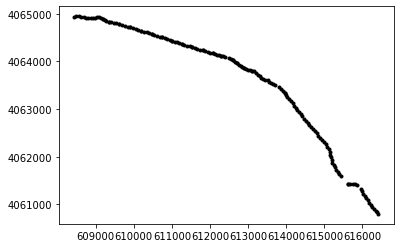

In [42]:
plt.plot(xy[:,0], xy[:,1], 'k.')

In [43]:
i_start_hm = 10
i_start_lm = 10

lm_inds = np.array(['DBDT_Ch1' in key.split('GT') for key in df.keys()], dtype=bool)
hm_inds = np.array(['DBDT_Ch2' in key.split('GT') for key in df.keys()], dtype=bool)
lm_header = (df.keys()[lm_inds])[i_start_lm:]
hm_header = (df.keys()[hm_inds])[i_start_hm:]
data_hm = df.loc[np.logical_and(df.CHANNEL_NO==2, df.LINE_NO == line),hm_header].values[:,:]
data_lm = df.loc[np.logical_and(df.CHANNEL_NO==1, df.LINE_NO == line),lm_header].values[:,:]

# dobs = np.hstack((data_hm, data_lm)).flatten() * unit_conversion

In [44]:
floor_hm = 0.
floor_lm = 0.
std = 0.05
data_hm[np.isnan(data_hm)] = 9999.
data_lm[np.isnan(data_lm)] = 9999.
dobs = np.hstack((data_hm/area, data_lm/area)).flatten()
uncert = np.hstack((abs(data_hm/area)*std + floor_hm, abs(data_lm/area)*std + floor_lm)).flatten()
survey.dobs = -dobs.copy() 
inactive_inds = dobs==9999./area
uncert[inactive_inds] = np.Inf




In [45]:
print('survey.nD size',survey.nD)
print('uncert size',uncert.size)

survey.nD size 7470
uncert size 7470


In [46]:
len(time)*len(time[0])

4482

In [47]:
# s = (1e-2,1e-2,10,)
# x = (1e-2,10., 1.,)
# y = (1e-2,1.,  1.,)  
# for alpha_s,alpha_x,alpha_y in zip(s,x,y):
alpha_s,alpha_x,alpha_y = (1e-2, 10., 1. )



mesh = get_2d_mesh(n_sounding, hz)
m0 = np.ones(mesh.nC) * np.log(1./10.)
regmap = Maps.IdentityMap(mesh)

# mapping is required ... for IRLS
reg = LateralConstraint(
    mesh, mapping=regmap,
    alpha_s =  alpha_s,
    alpha_x =  alpha_x,
    alpha_y =  alpha_y,    
)
reg.get_grad_horizontal(xy[:,:], hz, dim=3, use_cell_weights=True, minimum_distance=1000.)

np.random.seed(1)
dmisfit = DataMisfit.l2_DataMisfit(survey,std=.03)
dmisfit.W = 1./uncert

p = 0
qx, qz = 1., 1.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=5, minGNiter=1, fix_Jmatrix=True,
    betaSearch=False
)
opt = Optimization.ProjectedGNCG(maxIter = 30, maxIterCG=20)
# opt.upper = m_upper
# opt.lower = m_lower
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit(chifact=0.84)
sense = Directives.UpdateSensitivityWeights()
save_model = Directives.SaveOutputDictEveryIteration(directory="/scratch/users/ianpg/timelapseAEM/l2-m0-10ohmm-s{}x{}y{}/"
                                                     .format(int(100*alpha_s),int(100*alpha_x),int(100*alpha_y)))
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target, save_model, sense])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')


SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [48]:
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2020-02-23-20-30.npz'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.85e+00  3.26e+05  0.00e+00  3.26e+05    5.60e+03      0              
   1  2.92e+00  2.67e+05  3.47e+00  2.67e+05    5.09e+03      2              
   2  1.46e+00  2.45e+05  9.15e+00  2.45e+05    1.68e+04      0   Skip BFGS  
   3  7.31e-01  2.20e+05  1.30e+01  2.20e+05    2.77e+03      0              
   4  3.65e-01  2.20e+05  1.13e+01  2.20e+05    1.13e+04      1              
   5  1.83e-01  2

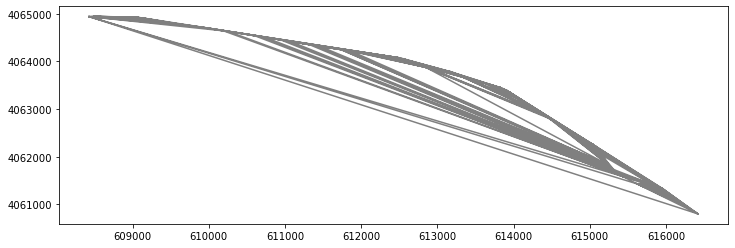

In [49]:
fig = plt.figure(figsize=(12, 4))
tri = reg.get_grad_horizontal(topo[:,:2], hz)
# plt.plot(topo_312[:,0], topo_312[:,1], 'o')
# plt.plot(topo_304[:,0], topo_304[:,1], 'o')
# plt.legend(("SkyTEM312", "SkyTEM304"))
plt.triplot(topo[:,0], topo[:,1], tri.simplices, color='grey')
plt.show()

/home/users/ianpg/miniconda3/envs/simpegEM1D-environment/lib/python3.8/site-packages/simpegEM1D/IO.py:54: UserWarning: code under construction - API might change in the future
  warnings.warn(


(<matplotlib.collections.QuadMesh at 0x7f781fcf4370>,
 <matplotlib.colorbar.Colorbar at 0x7f782083f190>)

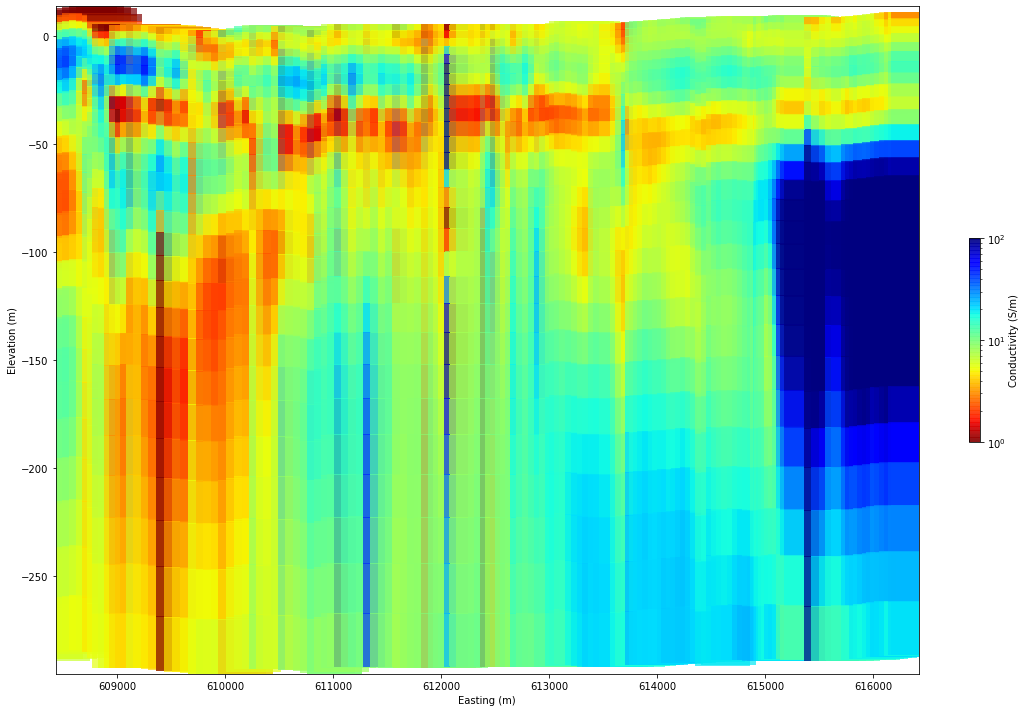

In [50]:
from matplotlib.colors import LogNorm
from simpegEM1D import ModelIO
nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[:,:], 
    physical_property=1./np.exp(Utils.mkvc(mopt.reshape((hz.size, n_sounding), order='F')[:,::nskip])),
    line=np.repeat(line, n_sounding)[::nskip].astype(float)
)

IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r', aspect=20, clim=(1, 100), dx=250, i_line=0)

In [51]:
dopt = survey.dpred(mopt)
# dpred = survey.dpred(m0)

(1e-14, 1e-08)

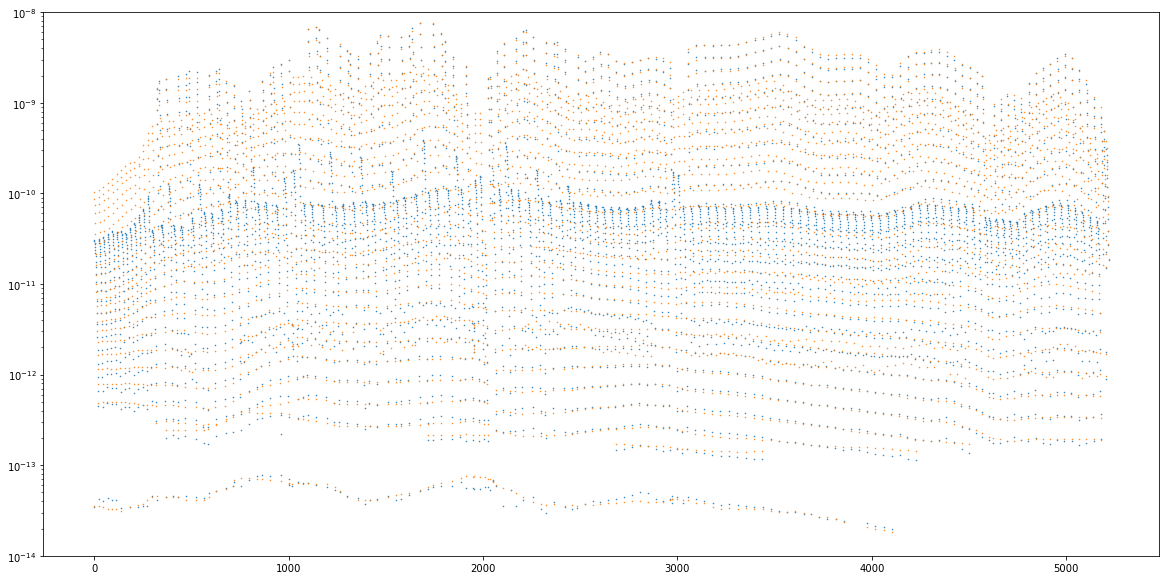

In [52]:
fig = plt.figure(figsize=(20, 10))
plt.semilogy(abs(dopt[~inactive_inds]), '.', ms=1)
plt.semilogy(abs(survey.dobs[~inactive_inds]), '.', ms=1)
plt.ylim(1e-14, 1e-8)

array([-3.35299012, -3.37396148, -3.37906508, ..., -3.30210968,
       -3.30201697, -3.3107969 ])

(<matplotlib.collections.QuadMesh at 0x2b3c5bf7e310>,
 <matplotlib.colorbar.Colorbar at 0x2b3c5bfb14d0>)

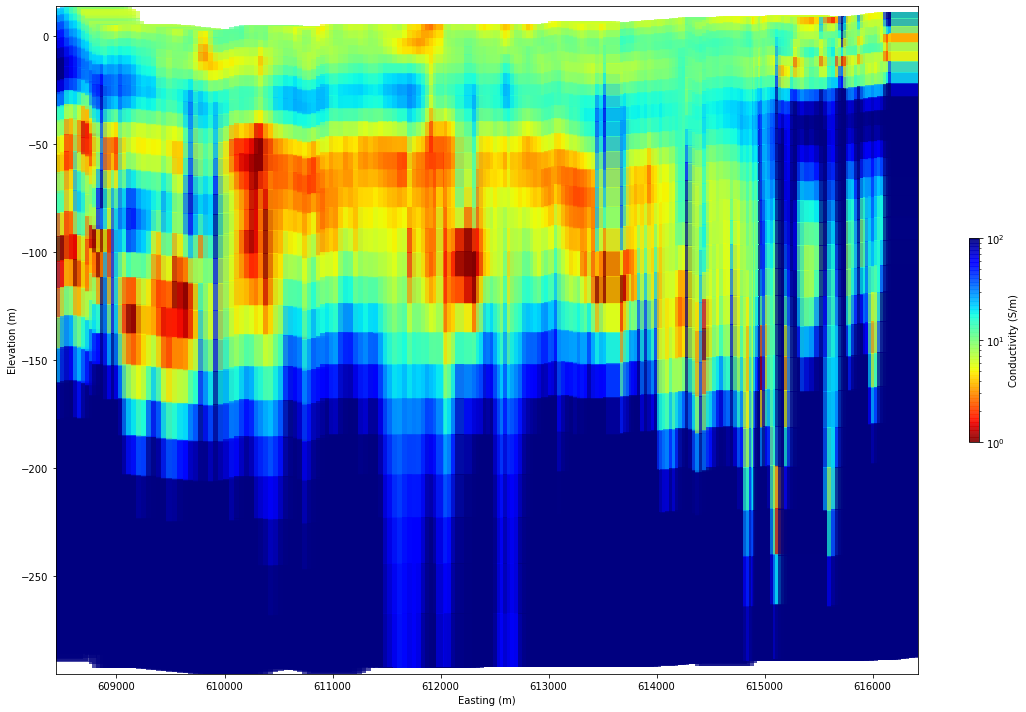

In [217]:
from matplotlib.colors import LogNorm
from simpegEM1D import ModelIO
nskip = 1
i_iter = 20
IO = ModelIO(
    hz=hz,
    topography=topo[1:,:], 
    physical_property=1./np.exp(Utils.mkvc(save_model.outDict[i_iter]['m'].reshape((hz.size, n_sounding), order='F')[:,::nskip])),
    line=np.repeat(line, n_sounding)[::nskip].astype(float)
)

IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r', aspect=20, clim=(1, 100), dx=250, i_line=0)

In [218]:
save_model.outDict

{1: {'iter': 1,
  'beta': 50789.68360811762,
  'phi_d': 566414145.454601,
  'phi_m': 0.42853789052615976,
  'f': 4670905956.628558,
  'm': array([-3.35299012, -3.37396148, -3.37906508, ..., -3.30210968,
         -3.30201697, -3.3107969 ]),
  'dpred': array([-1.61647383e-10, -1.39476655e-10, -1.17745307e-10, ...,
         -1.14703857e-12, -6.49677202e-13, -3.58571750e-13]),
  'eps_p': None,
  'eps_q': None,
  'lps': 0.0,
  'lpx': 1.0},
 2: {'iter': 2,
  'beta': 25394.84180405881,
  'phi_d': 75236365.83630483,
  'phi_m': 1.045192675752889,
  'f': 566438100.7430145,
  'm': array([-2.62644825, -2.79814235, -3.09751918, ..., -4.16695907,
         -4.26670505, -4.36369428]),
  'dpred': array([-1.88474277e-10, -1.57463800e-10, -1.28301074e-10, ...,
         -1.18444272e-12, -6.40013152e-13, -3.29692440e-13]),
  'eps_p': None,
  'eps_q': None,
  'lps': 0.0,
  'lpx': 1.0},
 3: {'iter': 3,
  'beta': 12697.420902029406,
  'phi_d': 11216206.435549939,
  'phi_m': 1.6508063404028952,
  'f': 75258186